<img src="11214_2020_717_Fig8_HTML.png" width="500">

In [17]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In this notebook we will study how BepiColombo's SIXS-P particle instrument detects electrons and protons, by examining some of the different ways the particles can deposit their kinetic energy in the detecting units/layers/materials of the instrument.

In [133]:
CORE_THRESHOLD = 0.5 # MeV
SIDE_THRESHOLD = 0.035 # MeV
FONTSIZE = 24

# Switch between low energy and high energy files
# User sets this
high_energies = False

# ------------------------------------------------------------------
# Reading the files

lowe_filenames = ["out_e.csv", "out_p.csv"]
highe_filenames = ["out_e_high.csv", "out_p_high.csv"]


filenames = highe_filenames if high_energies else lowe_filenames
dfs = [pd.read_csv(fname, ) for fname in filenames]

for df in dfs:
   df.sort_values(by="Egun_MeV", inplace=True, ignore_index=True)

display(dfs[0])
display(dfs[1])

,Egun_MeV,Edep_Kapton_foil0_MeV,Edep_Si_side0_MeV,Edep_Scintillator_MeV
0,0.040015,0.007999,0.000000,0.000000
1,0.040041,0.020730,0.000000,0.000000
2,0.040057,0.029845,0.000000,0.000000
3,0.040079,0.013006,0.000000,0.000000
4,0.040082,0.010329,0.000000,0.000000
...,...,...,...,...
10357,2.993074,0.001681,0.043913,1.004033
10358,2.994048,0.004757,0.000000,0.000000
10359,2.996588,0.001210,0.000000,0.543203
10360,2.998675,0.002008,0.000000,0.932350


,Egun_MeV,Edep_Kapton_foil0_MeV,Edep_Si_side0_MeV,Edep_Scintillator_MeV
0,0.801598,0.516755,0.0,0.000000
1,0.819952,0.515850,0.0,0.000000
2,0.822067,0.552641,0.0,0.000000
3,0.825561,0.562268,0.0,0.000000
4,0.839188,0.559907,0.0,0.000000
...,...,...,...,...
11026,29.993083,0.030943,0.0,0.000000
11027,29.993587,0.018019,0.0,22.720594
11028,29.993704,0.021468,0.0,22.667656
11029,29.996744,0.032442,0.0,1.133395


In [107]:
# Apply selection criteria here
df_p_coinc = dfs[1].loc[(dfs[1]["Edep_Scintillator_MeV"]>CORE_THRESHOLD)&(dfs[1]["Edep_Si_side0_MeV"] > SIDE_THRESHOLD)]
df_e_coinc = dfs[0].loc[(dfs[0]["Edep_Scintillator_MeV"]>CORE_THRESHOLD)&(dfs[0]["Edep_Si_side0_MeV"] > SIDE_THRESHOLD)]

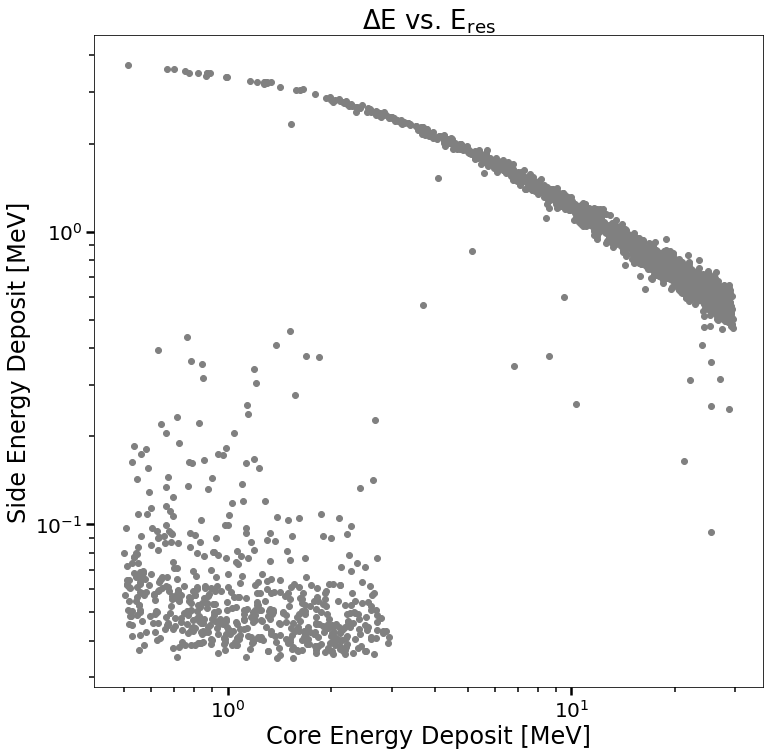

In [108]:
XAXIS = "Edep_Scintillator_MeV"
YAXIS = "Edep_Si_side0_MeV"

TITLE = r"$\Delta$E vs. E$_{\rm res}$"
XAXIS_LABEL = "Core Energy Deposit [MeV]"
YAXIS_LABEL = "Side Energy Deposit [MeV]"

fig, ax = plt.subplots(figsize=(12,12))

ax.set_xscale("log")
ax.set_yscale("log")

# Protons
ax.scatter(df_p_coinc[XAXIS],df_p_coinc[YAXIS], color="grey")
ax.scatter(df_e_coinc[XAXIS],df_e_coinc[YAXIS], color="grey")

ax.set_ylabel(YAXIS_LABEL, fontsize=FONTSIZE)
ax.set_xlabel(XAXIS_LABEL, fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=20, length=8, width=2.5)
ax.tick_params(axis='both', which='minor', labelsize=17, length=5, width=1.5)

ax.set_title(TITLE, fontsize=FONTSIZE+2)

plt.show()

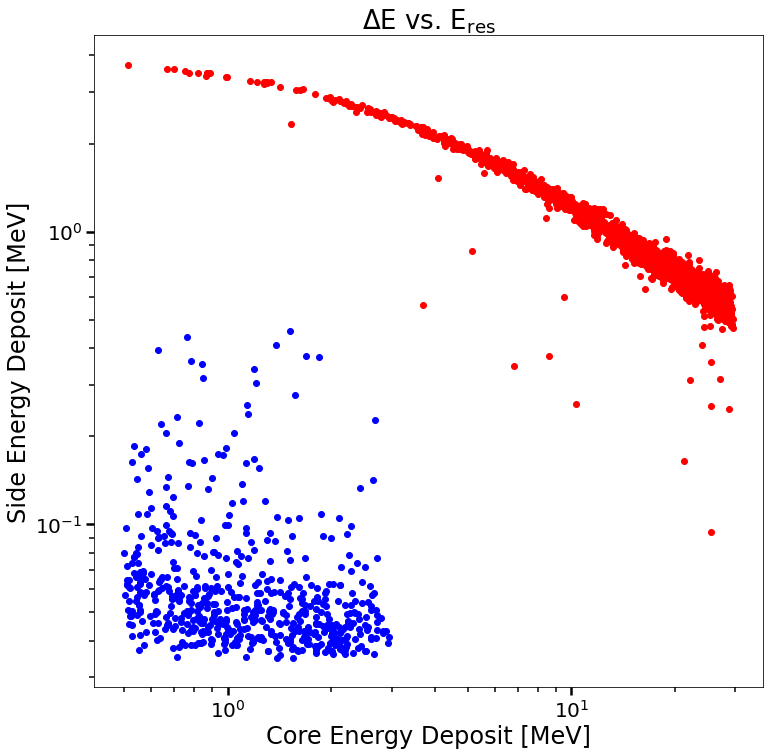

In [109]:
XAXIS = "Edep_Scintillator_MeV"
YAXIS = "Edep_Si_side0_MeV"

TITLE = r"$\Delta$E vs. E$_{\rm res}$"
XAXIS_LABEL = "Core Energy Deposit [MeV]"
YAXIS_LABEL = "Side Energy Deposit [MeV]"

fig, ax = plt.subplots(figsize=(12,12))

ax.set_xscale("log")
ax.set_yscale("log")

# Protons
ax.scatter(df_p_coinc[XAXIS],df_p_coinc[YAXIS], color="red")
ax.scatter(df_e_coinc[XAXIS],df_e_coinc[YAXIS], color="blue")

ax.set_ylabel(YAXIS_LABEL, fontsize=FONTSIZE)
ax.set_xlabel(XAXIS_LABEL, fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=20, length=8, width=2.5)
ax.tick_params(axis='both', which='minor', labelsize=17, length=5, width=1.5)

ax.set_title(TITLE, fontsize=FONTSIZE+2)

plt.show()

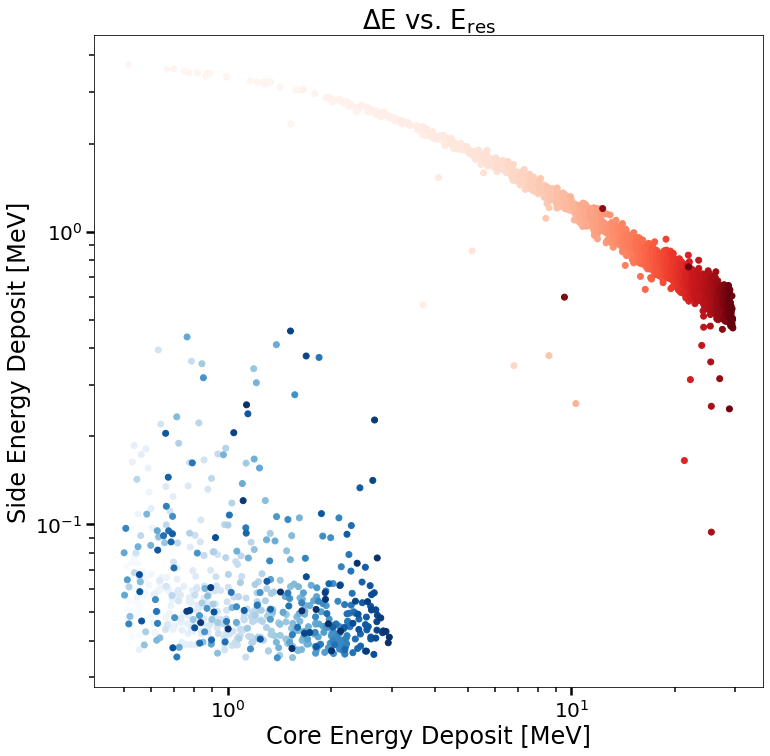

In [110]:
XAXIS = "Edep_Scintillator_MeV"
YAXIS = "Edep_Si_side0_MeV"

TITLE = r"$\Delta$E vs. E$_{\rm res}$"
XAXIS_LABEL = "Core Energy Deposit [MeV]"
YAXIS_LABEL = "Side Energy Deposit [MeV]"

E_CMAP = plt.get_cmap("Blues", 60)
P_CMAP = plt.get_cmap("Reds", 60)

fig, ax = plt.subplots(figsize=(12,12))

ax.set_xscale("log")
ax.set_yscale("log")

# Protons
ax.scatter(df_p_coinc[XAXIS],df_p_coinc[YAXIS], c=df_p_coinc["Egun_MeV"], cmap=P_CMAP)
# Electrons
ax.scatter(df_e_coinc[XAXIS],df_e_coinc[YAXIS], c=df_e_coinc["Egun_MeV"], cmap=E_CMAP)

ax.set_ylabel(YAXIS_LABEL, fontsize=FONTSIZE)
ax.set_xlabel(XAXIS_LABEL, fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=20, length=8, width=2.5)
ax.tick_params(axis='both', which='minor', labelsize=17, length=5, width=1.5)

ax.set_title(TITLE, fontsize=FONTSIZE+2)

plt.show()

In [111]:
# Apply (different) selection criteria here
df_p_ac = dfs[1].loc[(dfs[1]["Edep_Scintillator_MeV"]<CORE_THRESHOLD)&(dfs[1]["Edep_Si_side0_MeV"] > SIDE_THRESHOLD)]
df_e_ac = dfs[0].loc[(dfs[0]["Edep_Scintillator_MeV"]<CORE_THRESHOLD)&(dfs[0]["Edep_Si_side0_MeV"] > SIDE_THRESHOLD)]

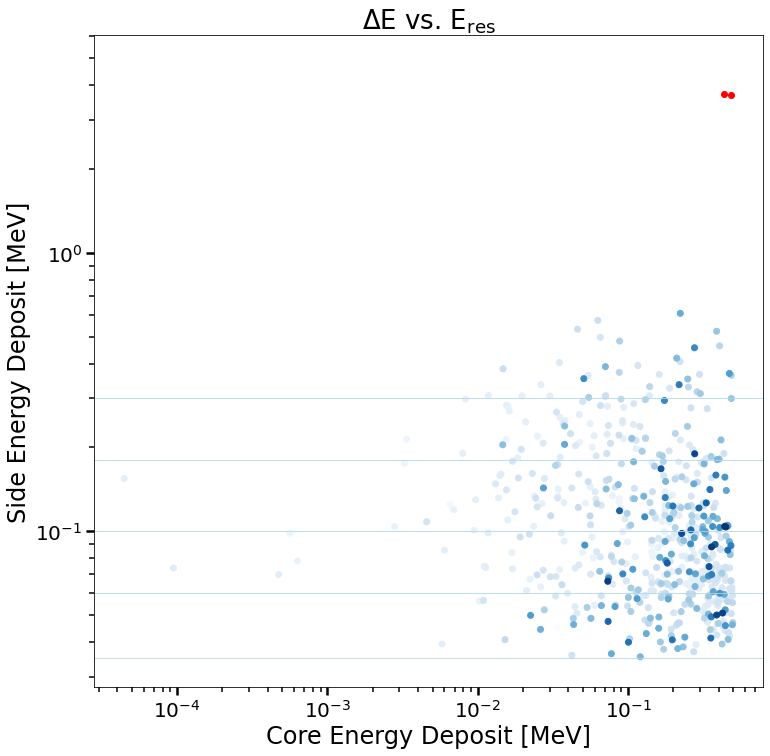

In [112]:
XAXIS = "Edep_Scintillator_MeV"
YAXIS = "Edep_Si_side0_MeV"

TITLE = r"$\Delta$E vs. E$_{\rm res}$"
XAXIS_LABEL = "Core Energy Deposit [MeV]"
YAXIS_LABEL = "Side Energy Deposit [MeV]"

# In MeV
e_channel_boundaries = [0.035, 0.06, 0.1, 0.18, 0.3]

fig, ax = plt.subplots(figsize=(12,12))

ax.set_xscale("log")
ax.set_yscale("log")

# Protons
ax.scatter(df_p_ac[XAXIS],df_p_ac[YAXIS], color="red")
ax.scatter(df_e_ac[XAXIS],df_e_ac[YAXIS], c=df_e_ac["Egun_MeV"], cmap=E_CMAP)

for boundary in e_channel_boundaries:
    ax.axhline(y=boundary, lw=0.8, c="lightblue")

ax.set_ylabel(YAXIS_LABEL, fontsize=FONTSIZE)
ax.set_xlabel(XAXIS_LABEL, fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=20, length=8, width=2.5)
ax.tick_params(axis='both', which='minor', labelsize=17, length=5, width=1.5)

ax.set_title(TITLE, fontsize=FONTSIZE+2)

plt.show()

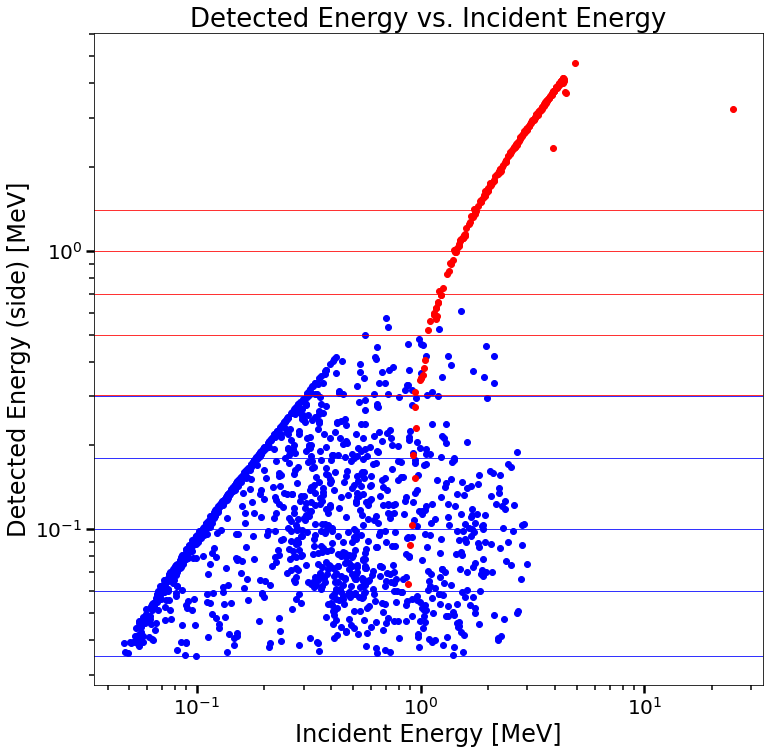

In [113]:
XAXIS = "Egun_MeV"
YAXIS = "Edep_Si_side0_MeV"

TITLE = r"Detected Energy vs. Incident Energy"
XAXIS_LABEL = "Incident Energy [MeV]"
YAXIS_LABEL = "Detected Energy (side) [MeV]"

# In MeV
e_channel_boundaries = [0.035, 0.06, 0.1, 0.18, 0.3]
p_channel_boundaries = [0.303, 0.5, 0.7, 1., 1.4]

fig, ax = plt.subplots(figsize=(12,12))

ax.set_xscale("log")
ax.set_yscale("log")

# Protons
ax.scatter(df_p_ac[XAXIS],df_p_ac[YAXIS], color="red", zorder=3)
ax.scatter(df_e_ac[XAXIS],df_e_ac[YAXIS], color="blue")

for boundary in e_channel_boundaries:
    ax.axhline(y=boundary, lw=0.8, c="blue")

for boundary in p_channel_boundaries:
    ax.axhline(y=boundary, lw=0.8, c="red")

ax.set_ylabel(YAXIS_LABEL, fontsize=FONTSIZE)
ax.set_xlabel(XAXIS_LABEL, fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=20, length=8, width=2.5)
ax.tick_params(axis='both', which='minor', labelsize=17, length=5, width=1.5)

ax.set_title(TITLE, fontsize=FONTSIZE+2)

plt.show()

In [114]:
e1_selection = df_e_ac.loc[(df_e_ac["Edep_Si_side0_MeV"]>e_channel_boundaries[0])&(df_e_ac["Edep_Si_side0_MeV"]<e_channel_boundaries[1])]

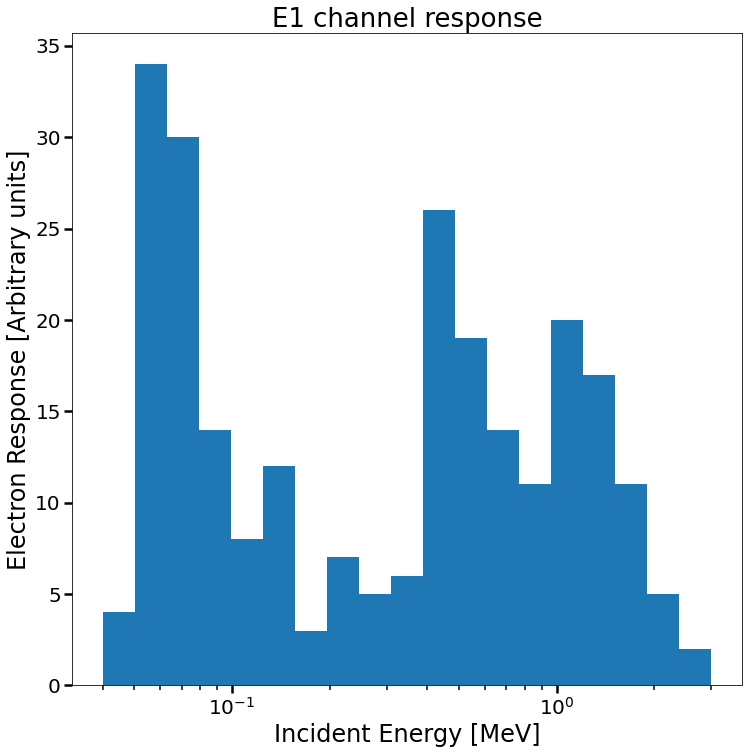

In [129]:
XAXIS_LABEL = "Incident Energy [MeV]"
YAXIS_LABEL = "Electron Response [Arbitrary units]"
TITLE = "E1 channel response"

fig, ax = plt.subplots(figsize=(12,12))

ax.set_xscale("log")

ax.hist(e1_selection["Egun_MeV"], bins=np.logspace(np.log10(0.04),np.log10(3),20))

ax.set_ylabel(YAXIS_LABEL, fontsize=FONTSIZE)
ax.set_xlabel(XAXIS_LABEL, fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=20, length=8, width=2.5)
ax.tick_params(axis='both', which='minor', labelsize=17, length=5, width=1.5)

ax.set_title(TITLE, fontsize=FONTSIZE+2)

plt.show()

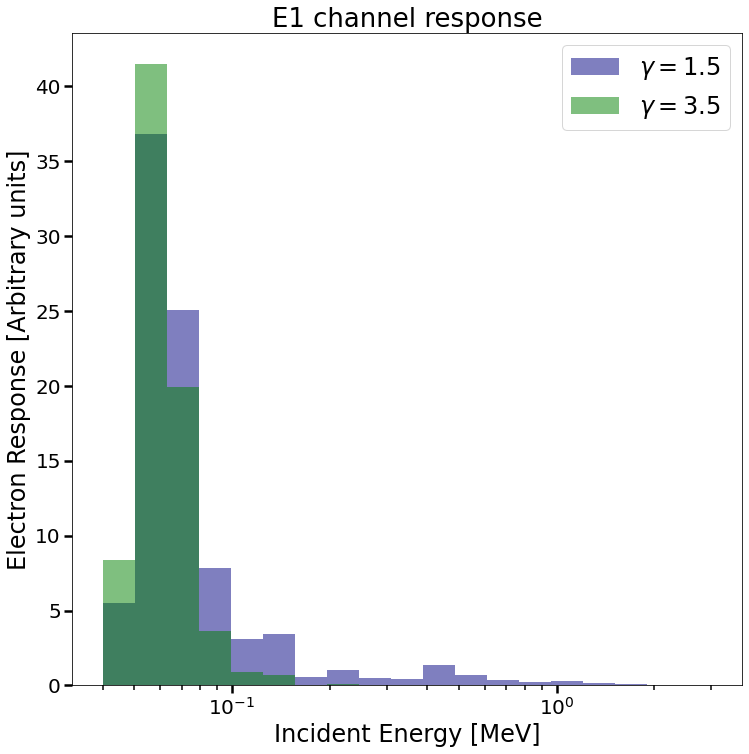

In [128]:
XAXIS_LABEL = "Incident Energy [MeV]"
YAXIS_LABEL = "Electron Response [Arbitrary units]"
TITLE = "E1 channel response"

fig, ax = plt.subplots(figsize=(12,12))

ax.set_xscale("log")

ax.hist(e1_selection["Egun_MeV"], bins=np.logspace(np.log10(0.04),np.log10(3),20), weights=np.power(e1_selection["Egun_MeV"]/0.06,-1.5), alpha=0.5, color="navy", label=r"$\gamma=1.5$")
ax.hist(e1_selection["Egun_MeV"], bins=np.logspace(np.log10(0.04),np.log10(3),20), weights=np.power(e1_selection["Egun_MeV"]/0.06,-3.5), alpha=0.5, color="green", label=r"$\gamma=3.5$")

ax.set_ylabel(YAXIS_LABEL, fontsize=FONTSIZE)
ax.set_xlabel(XAXIS_LABEL, fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=20, length=8, width=2.5)
ax.tick_params(axis='both', which='minor', labelsize=17, length=5, width=1.5)

ax.set_title(TITLE, fontsize=FONTSIZE+2)
ax.legend(fontsize=FONTSIZE)

plt.show()